# House Price Advanced Regression (xgboost)

!pip install xgboost
!pip install missingno
!pip install scikit-learn

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.impute import SimpleImputer
from sklearn.ensemble import StackingRegressor
import xgboost as xgb
from scipy import stats
from scipy.stats import norm, skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

### Loading Data

In [ ]:
train_df = pd.read_csv('C:/Users/HousePrice_adv_reg/train.csv')
test_df = pd.read_csv('C:/Users/HousePrice_adv_reg/test.csv')

#### Exploratory Data Analysis

In [3]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [7]:
# Which columns have nan?
print('training data+++++++++++++++++++')
for i in np.arange(train_df.shape[1]):
    n = train_df.iloc[:,i].isnull().sum()
    if n > 0:
        print(list(train_df.columns.values)[i] + ': ' +str(n) + ' nans')

print('testing data++++++++++++++++++++')
for i in np.arange(test_df.shape[1]):
    n = test_df.iloc[:,i].isnull().sum()
    if n > 0:
        print(list(test_df.columns.values)[i] + ': ' +str(n) + ' nans')

training data+++++++++++++++++++
LotFrontage: 259 nans
Alley: 1369 nans
MasVnrType: 872 nans
MasVnrArea: 8 nans
BsmtQual: 37 nans
BsmtCond: 37 nans
BsmtExposure: 38 nans
BsmtFinType1: 37 nans
BsmtFinType2: 38 nans
Electrical: 1 nans
FireplaceQu: 690 nans
GarageType: 81 nans
GarageYrBlt: 81 nans
GarageFinish: 81 nans
GarageQual: 81 nans
GarageCond: 81 nans
PoolQC: 1453 nans
Fence: 1179 nans
MiscFeature: 1406 nans
testing data++++++++++++++++++++
MSZoning: 4 nans
LotFrontage: 227 nans
Alley: 1352 nans
Utilities: 2 nans
Exterior1st: 1 nans
Exterior2nd: 1 nans
MasVnrType: 894 nans
MasVnrArea: 15 nans
BsmtQual: 44 nans
BsmtCond: 45 nans
BsmtExposure: 44 nans
BsmtFinType1: 42 nans
BsmtFinSF1: 1 nans
BsmtFinType2: 42 nans
BsmtFinSF2: 1 nans
BsmtUnfSF: 1 nans
TotalBsmtSF: 1 nans
BsmtFullBath: 2 nans
BsmtHalfBath: 2 nans
KitchenQual: 1 nans
Functional: 2 nans
FireplaceQu: 730 nans
GarageType: 76 nans
GarageYrBlt: 78 nans
GarageFinish: 78 nans
GarageCars: 1 nans
GarageArea: 1 nans
GarageQual: 78

In [8]:
# Data cleaning strategy

# Column removal
train_df = train_df.drop(['Alley','Fence','FireplaceQu','PoolQC','MasVnrType','MiscFeature'], axis=1)

# Row removal for specific columns (use of 'subset' argument)
columns_to_check = ['LotFrontage','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond','MasVnrArea']
train_df = train_df.dropna(subset=columns_to_check, axis=0)

In [9]:
# Which columns have nan?
print('training data+++++++++++++++++++')
for i in np.arange(train_df.shape[1]):
    n = train_df.iloc[:,i].isnull().sum()
    if n > 0:
        print(list(train_df.columns.values)[i] + ': ' +str(n) + ' nans')

print('testing data++++++++++++++++++++')
for i in np.arange(test_df.shape[1]):
    n = test_df.iloc[:,i].isnull().sum()
    if n > 0:
        print(list(test_df.columns.values)[i] + ': ' +str(n) + ' nans')

training data+++++++++++++++++++
Electrical: 1 nans
testing data++++++++++++++++++++
MSZoning: 4 nans
LotFrontage: 227 nans
Alley: 1352 nans
Utilities: 2 nans
Exterior1st: 1 nans
Exterior2nd: 1 nans
MasVnrType: 894 nans
MasVnrArea: 15 nans
BsmtQual: 44 nans
BsmtCond: 45 nans
BsmtExposure: 44 nans
BsmtFinType1: 42 nans
BsmtFinSF1: 1 nans
BsmtFinType2: 42 nans
BsmtFinSF2: 1 nans
BsmtUnfSF: 1 nans
TotalBsmtSF: 1 nans
BsmtFullBath: 2 nans
BsmtHalfBath: 2 nans
KitchenQual: 1 nans
Functional: 2 nans
FireplaceQu: 730 nans
GarageType: 76 nans
GarageYrBlt: 78 nans
GarageFinish: 78 nans
GarageCars: 1 nans
GarageArea: 1 nans
GarageQual: 78 nans
GarageCond: 78 nans
PoolQC: 1456 nans
Fence: 1169 nans
MiscFeature: 1408 nans
SaleType: 1 nans


In [10]:
# How many columns with different datatypes are there?
train_df.dtypes.value_counts()

object     37
int64      35
float64     3
Name: count, dtype: int64

In [11]:
test_df.dtypes.value_counts()

object     43
int64      26
float64    11
Name: count, dtype: int64

In [12]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,...,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000
mean,727.971689,56.150685,70.761644,10131.983562,6.246575,5.575342,1972.442922,1985.935160,109.755251,447.782648,...,94.347032,46.904110,22.032877,3.263927,16.483105,3.004566,23.528767,6.334247,2007.786301,187015.424658
std,421.225013,41.963357,24.497748,8208.504232,1.366692,1.066155,31.192013,20.930904,190.609209,468.709555,...,122.568677,64.805918,61.545964,29.642580,58.430707,40.694665,167.060348,2.693629,1.333712,83129.409542
min,1.000000,20.000000,21.000000,1300.000000,2.000000,2.000000,1880.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,35311.000000
25%,367.000000,20.000000,60.000000,7614.500000,5.000000,5.000000,1953.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,132500.000000
50%,724.000000,50.000000,70.000000,9450.000000,6.000000,5.000000,1975.000000,1995.000000,0.000000,384.000000,...,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,166000.000000
75%,1094.500000,70.000000,80.000000,11380.500000,7.000000,6.000000,2003.000000,2005.000000,171.500000,712.500000,...,169.500000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,221000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,648.000000,2500.000000,12.000000,2010.000000,755000.000000


In [13]:
test_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


### Outliers

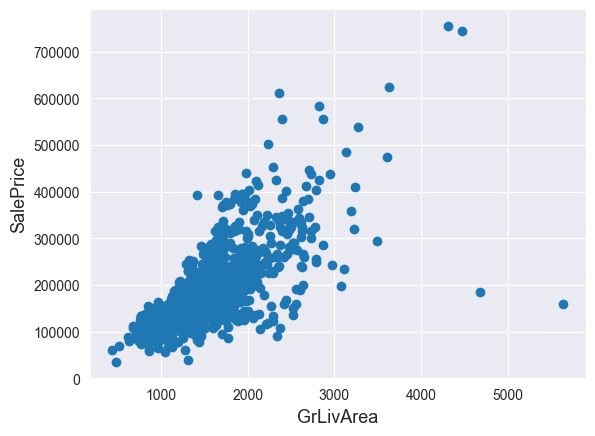

In [14]:
fig, ax = plt.subplots()
ax.scatter(x = train_df['GrLivArea'], y = train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

###### We can see at the bottom right two with extremely large GrLivArea that are of a low price. These values are huge outliers. Therefore, we can safely delete them.

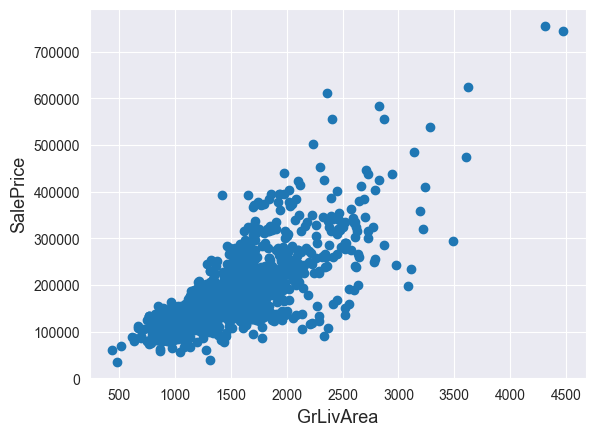

In [15]:
# Deleting outliers
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index)

# Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train_df['GrLivArea'], train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

###### Note : Outliers removal is not always safe. I have decided to delete these two as they are very huge (extremely large areas for very low prices).

### Correlation in Data

In [16]:
corr = train_df.select_dtypes(include=[np.number]).corr()["SalePrice"].sort_values(ascending=False)
print(corr)

SalePrice        1.000000
OverallQual      0.801792
GrLivArea        0.743682
TotalBsmtSF      0.675421
1stFlrSF         0.653604
GarageCars       0.653043
GarageArea       0.629987
FullBath         0.580219
TotRmsAbvGrd     0.566648
YearBuilt        0.523911
YearRemodAdd     0.520231
GarageYrBlt      0.502686
MasVnrArea       0.492219
Fireplaces       0.462449
BsmtFinSF1       0.408792
LotFrontage      0.364692
OpenPorchSF      0.347176
WoodDeckSF       0.330872
LotArea          0.312472
2ndFlrSF         0.304114
HalfBath         0.259783
BsmtFullBath     0.226108
BsmtUnfSF        0.191300
BedroomAbvGr     0.168515
ScreenPorch      0.106455
PoolArea         0.102227
MoSold           0.052269
3SsnPorch        0.033936
LowQualFinSF    -0.003553
YrSold          -0.006726
MiscVal         -0.036017
BsmtFinSF2      -0.036956
BsmtHalfBath    -0.041369
Id              -0.047531
MSSubClass      -0.089560
KitchenAbvGr    -0.115406
OverallCond     -0.138591
EnclosedPorch   -0.161763
Name: SalePr

###### OverallQual, GrLivArea, GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF, FullBath, TotRmsAbvGrd, YearBuilt, YearRemodAdd have more than 0.5 correlation with SalePrice.
###### EnclosedPorch and KitchenAbvGr have little negative correlation with target variable. 
###### These can prove to be important features to predict SalePrice.

Text(0.5, 1.0, 'Correlation Coefficients w.r.t. Sale Price')

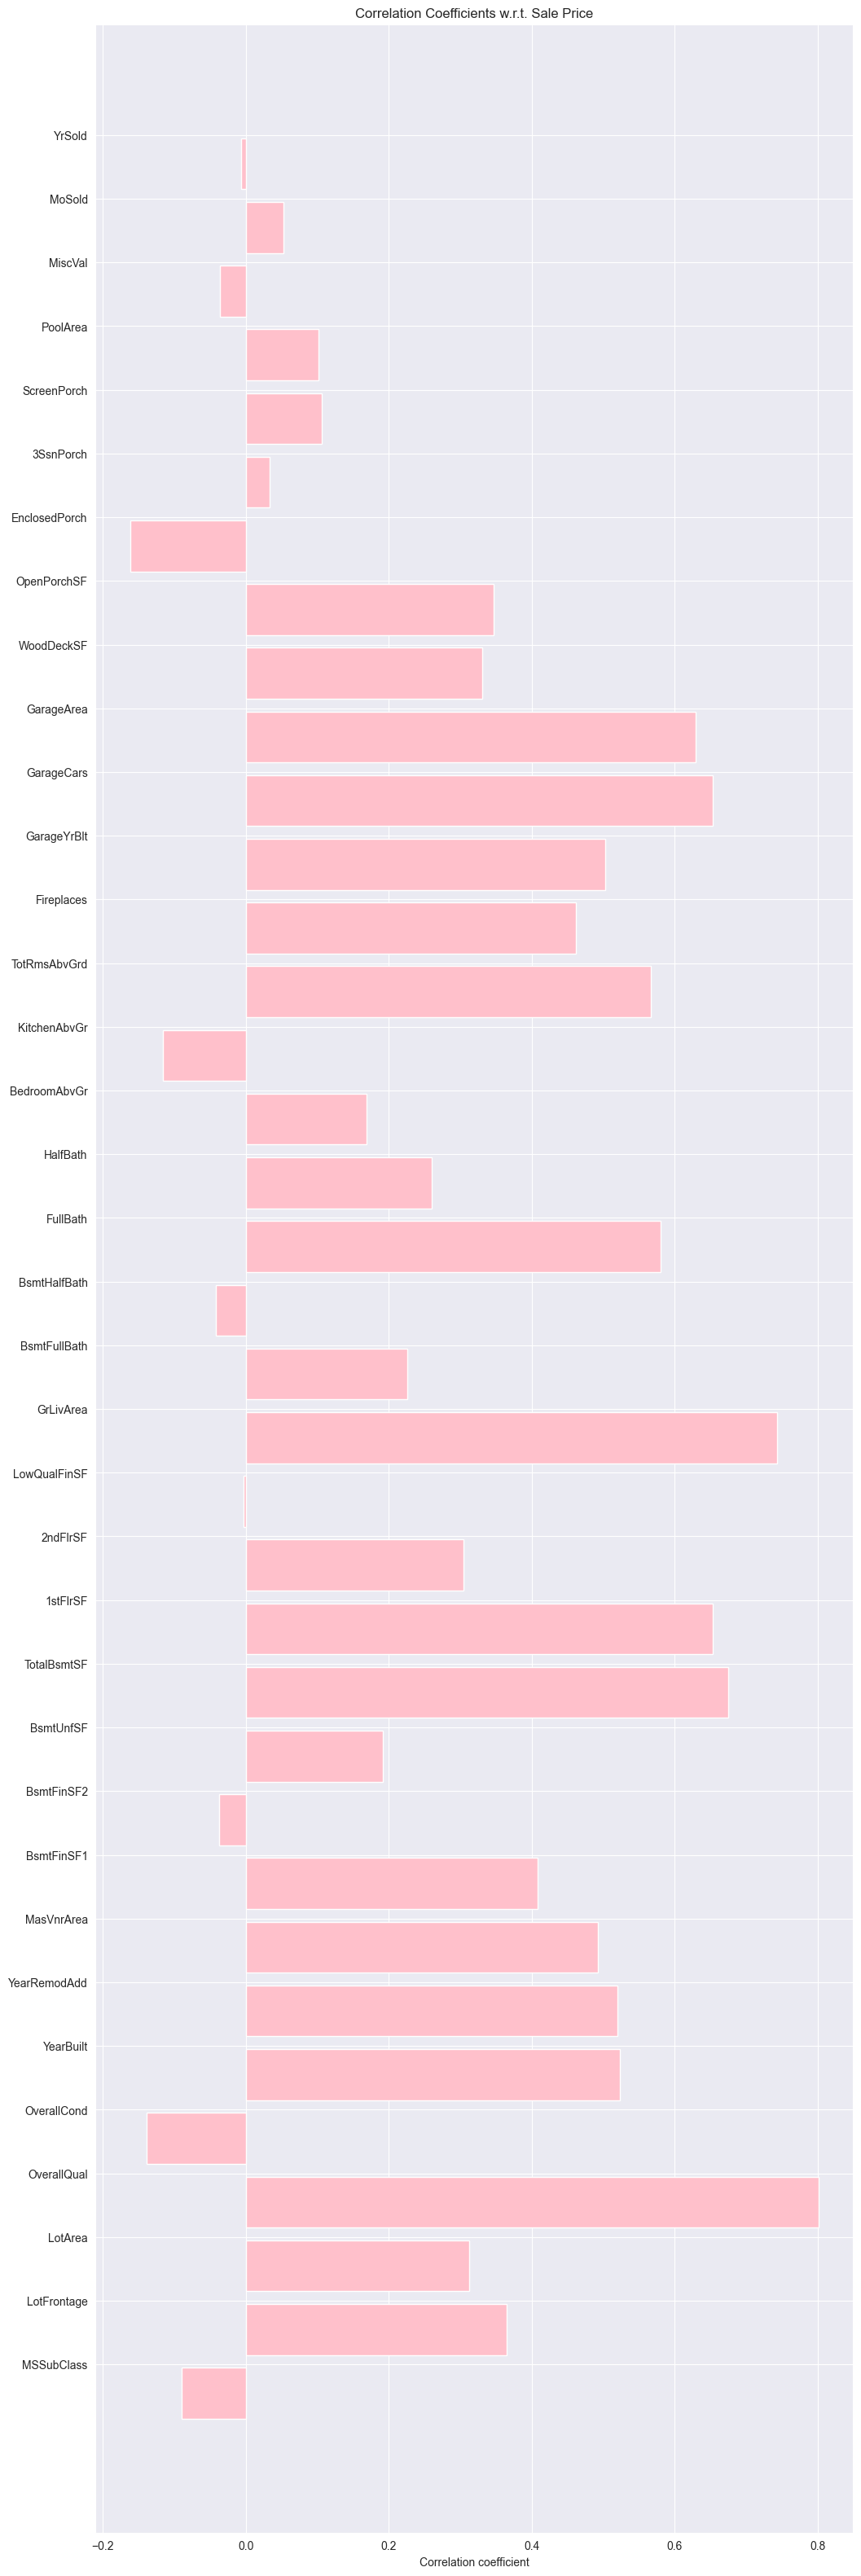

In [17]:
# Plotting correlations
num_feat = train_df.columns[train_df.dtypes!=object]
num_feat = num_feat[1:-1]
labels = []
values = []
for col in num_feat:
    labels.append(col)
    values.append(np.corrcoef(train_df[col].values, train_df.SalePrice.values)[0,1])

ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(values), color='pink')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation Coefficients w.r.t. Sale Price")

In [18]:
# Select only numeric columns for correlation
numeric_df = train_df.select_dtypes(include=[np.number])

# Compute correlations
correlations = numeric_df.corr()

# Excluding target if we have one (replacing 'target' with our actual target column)
attrs = correlations.iloc[:-1, :-1]

# Find important correlations above threshold
threshold = 0.5
important_corrs = (
    attrs[abs(attrs) > threshold][attrs != 1.0]
    .unstack()
    .dropna()
    .to_dict()
)

# Remove duplicate pairs (A,B) vs (B,A)
unique_important_corrs = pd.DataFrame(
    list(set([(tuple(sorted(key)), val) for key, val in important_corrs.items()])),
    columns=['Attribute Pair', 'Correlation']
)

# Sort by absolute correlation
unique_important_corrs = unique_important_corrs.loc[
    abs(unique_important_corrs['Correlation']).argsort()[::-1]
]

unique_important_corrs

,Attribute Pair,Correlation
30,"(1stFlrSF, TotalBsmtSF)",0.898377
21,"(GarageArea, GarageCars)",0.848148
8,"(GrLivArea, TotRmsAbvGrd)",0.832432
1,"(GarageYrBlt, YearBuilt)",0.823941
2,"(2ndFlrSF, GrLivArea)",0.697948
20,"(BsmtFinSF1, BsmtFullBath)",0.655920
0,"(GarageYrBlt, YearRemodAdd)",0.647879
29,"(BedroomAbvGr, TotRmsAbvGrd)",0.646491
24,"(FullBath, GrLivArea)",0.629104
13,"(YearBuilt, YearRemodAdd)",0.625464


###### This shows multicollinearity. In regression, "multicollinearity" refers to features that are correlated with other features. Multicollinearity occurs when our model includes multiple factors that are correlated not just to our target variable, but also to each other.
###### Problem: Multicollinearity increases the standard errors of the coefficients. That means, multicollinearity makes some variables statistically insignificant when they should be significant.
###### Solutions: Completely remove those variables. Making new feature by adding them or by some other operation. Use PCA, which will reduce feature set to small number of non-collinear features.

### Heatmap

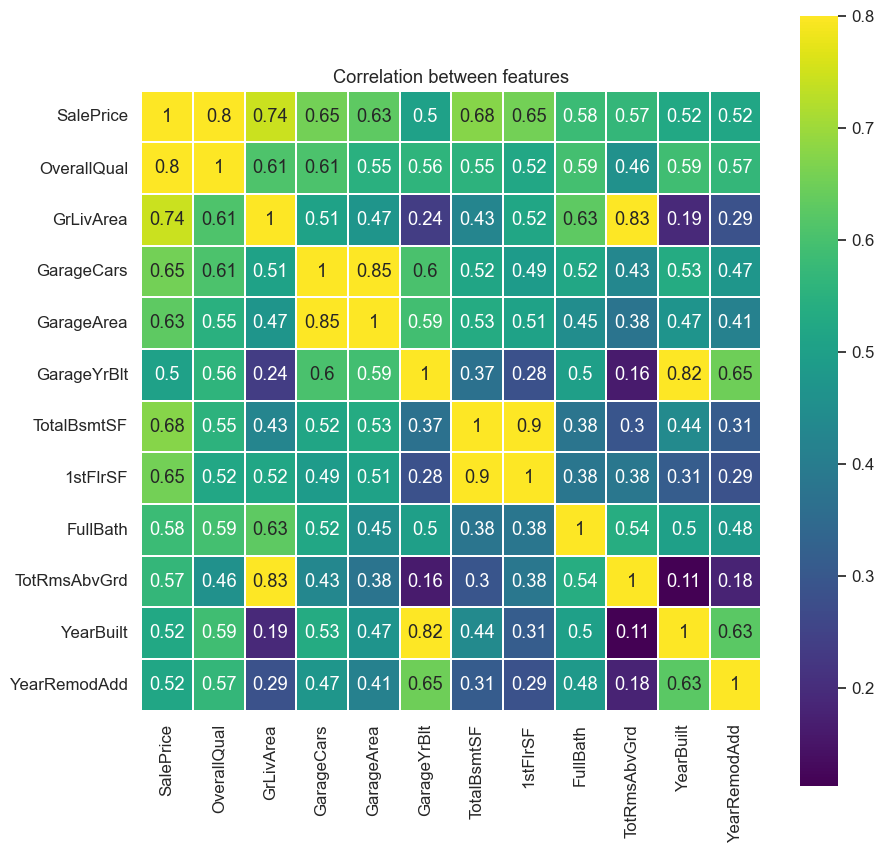

In [19]:
corrMatrix = train_df[["SalePrice", "OverallQual", "GrLivArea", "GarageCars", 
                       "GarageArea", "GarageYrBlt", "TotalBsmtSF", "1stFlrSF", "FullBath", 
                       "TotRmsAbvGrd", "YearBuilt", "YearRemodAdd"]].corr()

sns.set(font_scale=1.10)
plt.figure(figsize=(10, 10))

sns.heatmap(corrMatrix, vmax=0.8, linewidths=0.01,
            square=True, annot=True, cmap='viridis', linecolor="white")

plt.title('Correlation between features');

###### As we saw above there are few feature which shows high multicollinearity from heatmap. Lets focus on yellow squares on diagonal line and few on the sides.

###### (SalePrice and OverallQual), (GarageArea and GarageCars), (TotalBsmtSF and 1stFlrSF), (GrLiveArea and TotRmsAbvGrd), (YearBulit and GarageYrBlt)

###### We have to create a single feature from them before we use them as predictors.

### Pivotal Features

In [20]:
train_df[['OverallQual', 'SalePrice']].groupby(['OverallQual'],
as_index=False).mean().sort_values(by='OverallQual', ascending=False)

,OverallQual,SalePrice
8,10,472738.642857
7,9,368810.952381
6,8,278739.352518
5,7,207348.644788
4,6,158409.411111
3,5,133188.665529
2,4,109188.848485
1,3,98009.375000
0,2,47655.500000


In [21]:
train_df[['GarageCars','SalePrice']].groupby(['GarageCars'],
as_index=False).mean().sort_values(by='GarageCars', ascending=False)

,GarageCars,SalePrice
3,4,198819.750000
2,3,311096.313253
1,2,183332.004870
0,1,127255.237785


In [22]:
train_df[['Fireplaces','SalePrice']].groupby(['Fireplaces'],
as_index=False).mean().sort_values(by='Fireplaces', ascending=False)

,Fireplaces,SalePrice
3,3,303333.333333
2,2,250622.701299
1,1,218195.706587
0,0,146314.732422


### Viz of Target Variable

### Univariate Analysis

###### How 1 single variable is distributed in numeric range. What is statistical summary of it. Is it positively skewed or negatively.

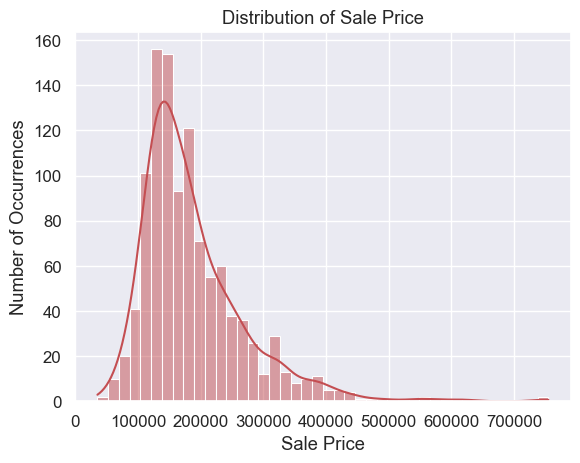

In [23]:
sns.histplot(train_df['SalePrice'], color="r", kde=True)
plt.title("Distribution of Sale Price")
plt.ylabel("Number of Occurrences")
plt.xlabel("Sale Price")
plt.show()

In [24]:
# Skewness
train_df['SalePrice'].skew()

np.float64(1.9309423912370958)

In [25]:
# Kurtosis
train_df['SalePrice'].kurtosis()

np.float64(6.415985689270084)

###### Prices are right skewed (positively skewed) and graph shows some peakedness.

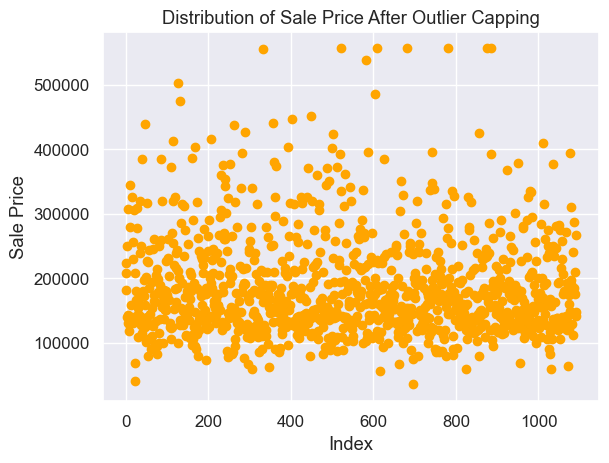

In [26]:
# Define upper limit (99.5th percentile)
upperlimit = np.percentile(train_df['SalePrice'].values, 99.5)

# Cap the outliers
train_df.loc[train_df['SalePrice'] > upperlimit, 'SalePrice'] = upperlimit

# Plot distribution after removing outliers
plt.scatter(range(train_df.shape[0]), train_df["SalePrice"].values, color='orange')
plt.title("Distribution of Sale Price After Outlier Capping")
plt.xlabel("Index")
plt.ylabel("Sale Price")
plt.show()

### Missing Value Imputation
###### Missing values in the training data set can affect prediction or classification of a model negatively.
###### Also some machine learning algorithms can't accept missing data eg. SVM.
###### But filling missing values with mean/median/mode or using another predictive model to predict missing values is also a prediction which may not be 100% accurate, instead we can use models like Decision Trees and Random Forest which handle missing values very well.

In [27]:
# Lets see if there are any columns having missing values
null_columns = train_df.columns[train_df.isnull().any()]
train_df[null_columns].isnull().sum()

Electrical    1
dtype: int64

### Multivariate Analysis
###### When we understand how 3 or more variables behave according to each other.
###### LotFrontage we can see if there is some correlation between LotArea and LotFrontage

In [28]:
train_df['SqrtLotArea']= np.sqrt(train_df['LotArea'])
train_df['LotFrontage'].corr(train_df['SqrtLotArea'])

np.float64(0.5742752427188345)

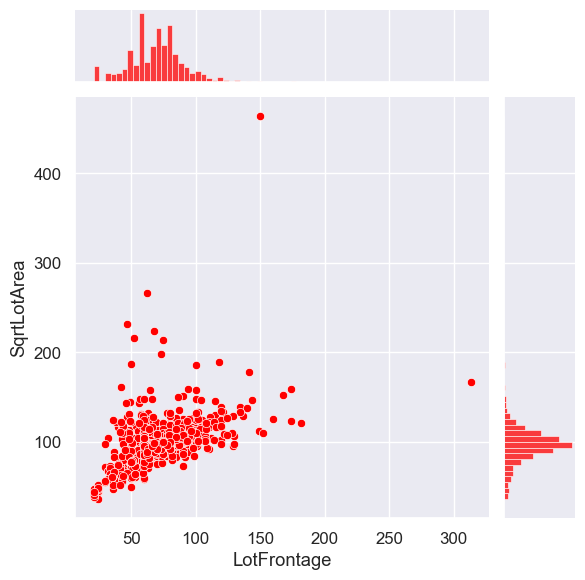

In [29]:
sns.jointplot(x='LotFrontage', y='SqrtLotArea', data=train_df, color='red')
plt.show()

##### MasVnrType and MasVnrArea

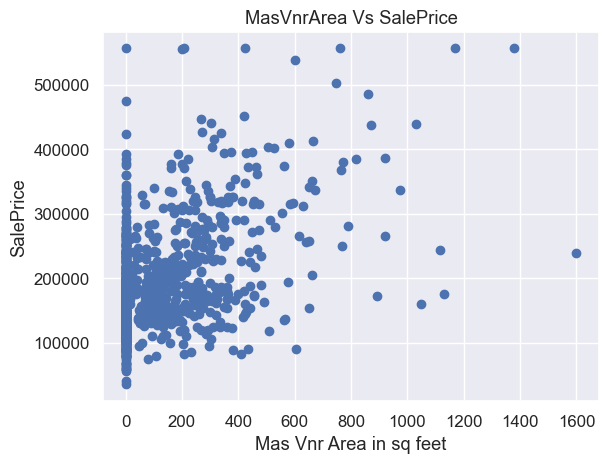

In [30]:
plt.scatter(train_df["MasVnrArea"], train_df["SalePrice"])
plt.title("MasVnrArea Vs SalePrice")
plt.ylabel("SalePrice")
plt.xlabel("Mas Vnr Area in sq feet");

### Bivariate Analysis
###### When we try to figure out how 2 parameters in dataset are related to each other. In the sense when one decreases, other also decreases or when one increases other also increases i.e Positive Correlation and when one increases , other decreases or vice versa i .e Negative correlation.
##### Electrical

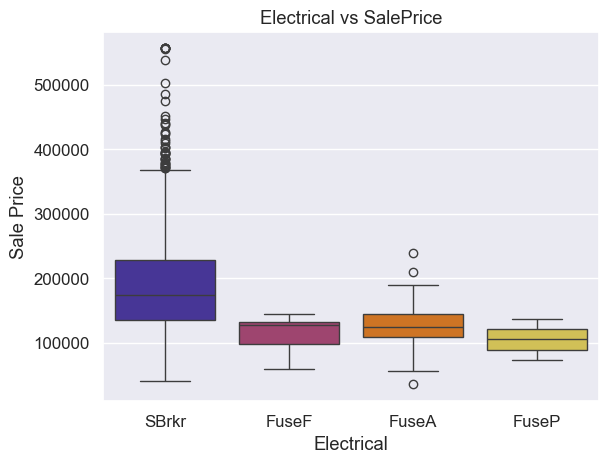

Electrical
SBrkr    1007
FuseA      67
FuseF      15
FuseP       2
Name: count, dtype: int64


In [31]:
train_df_filtered = train_df[train_df['Electrical'] != 'Mix']
sns.boxplot(x="Electrical", y="SalePrice", data=train_df_filtered, palette="CMRmap")
plt.title("Electrical vs SalePrice")
plt.ylabel("Sale Price")
plt.xlabel("Electrical")
plt.show()
print(train_df_filtered['Electrical'].value_counts())

##### Basement Features

Text(0.5, 0, 'Total Basement area in (SqFt)')

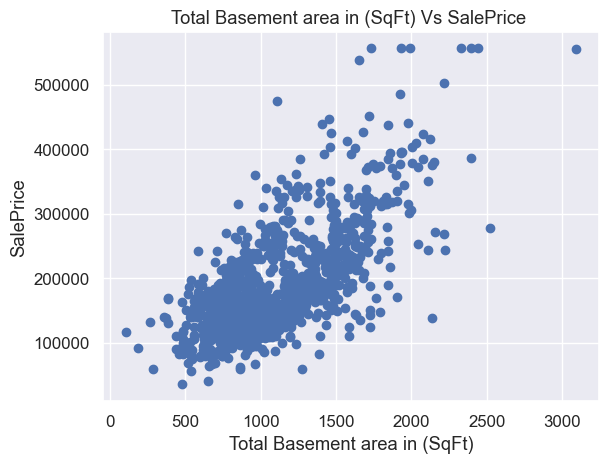

In [32]:
plt.scatter(train_df["TotalBsmtSF"],train_df["SalePrice"])
plt.title("Total Basement area in (SqFt) Vs SalePrice ")
plt.ylabel("SalePrice")
plt.xlabel("Total Basement area in (SqFt)")

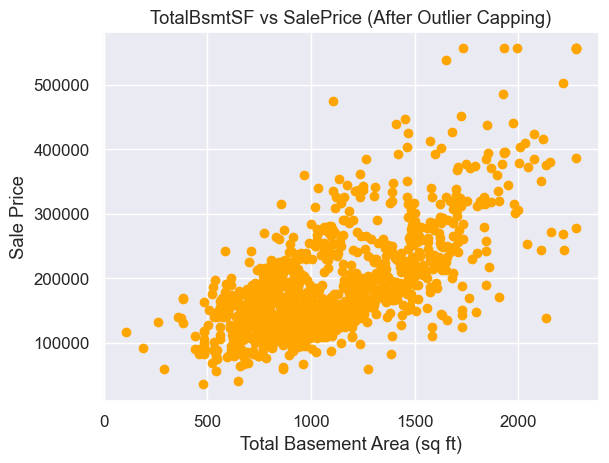

In [33]:
# Cap outliers in TotalBsmtSF
upperlimit = np.percentile(train_df['TotalBsmtSF'].values, 99.5)
train_df.loc[train_df['TotalBsmtSF'] > upperlimit, 'TotalBsmtSF'] = upperlimit

# Plot after capping
plt.scatter(train_df['TotalBsmtSF'], train_df['SalePrice'], color='orange')
plt.title("TotalBsmtSF vs SalePrice (After Outlier Capping)")
plt.ylabel("Sale Price")
plt.xlabel("Total Basement Area (sq ft)")
plt.show()

##### Garages

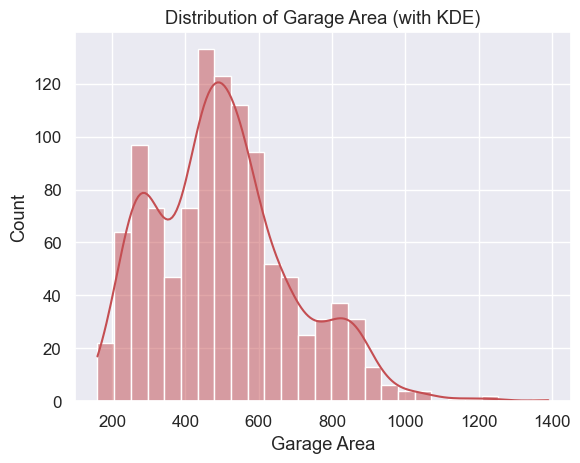

In [34]:
sns.histplot(train_df["GarageArea"], color='r', kde=True)
plt.title("Distribution of Garage Area (with KDE)")
plt.xlabel("Garage Area")
plt.ylabel("Count")
plt.show()

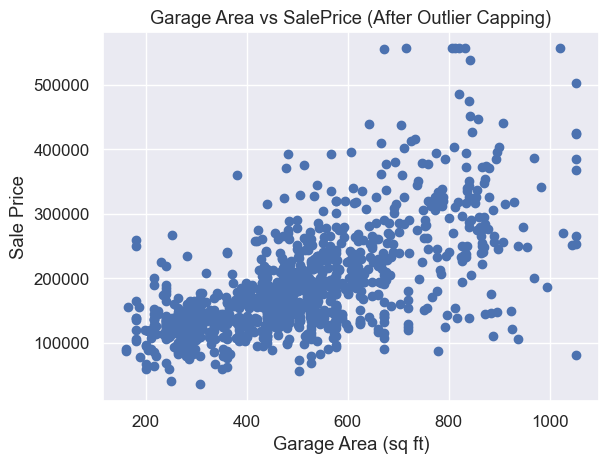

In [35]:
# Cap outliers in GarageArea 
upperlimit = np.percentile(train_df['GarageArea'].values, 99.5)
train_df.loc[train_df['GarageArea'] > upperlimit, 'GarageArea'] = upperlimit

# Plot after capping
plt.scatter(train_df['GarageArea'], train_df['SalePrice'])
plt.title("Garage Area vs SalePrice (After Outlier Capping)")
plt.ylabel("Sale Price")
plt.xlabel("Garage Area (sq ft)")
plt.show()

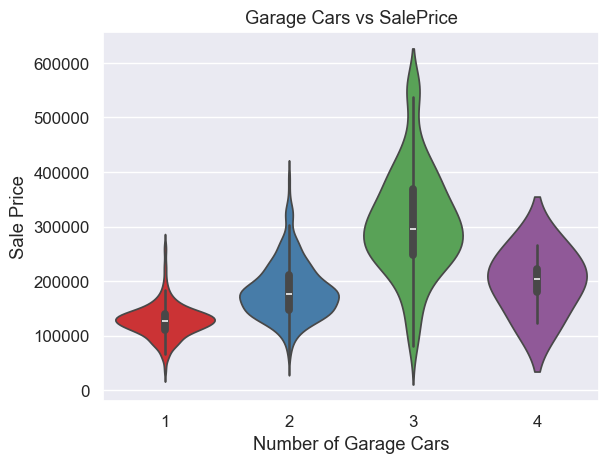

In [36]:
sns.violinplot(x="GarageCars", y="SalePrice", data=train_df, palette='Set1')
plt.title("Garage Cars vs SalePrice")
plt.ylabel("Sale Price")
plt.xlabel("Number of Garage Cars")
plt.show()

### Visualisations
##### MSZoning

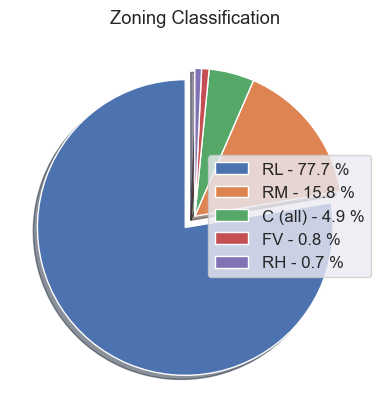

Text(0, 0.5, 'Sale Price')

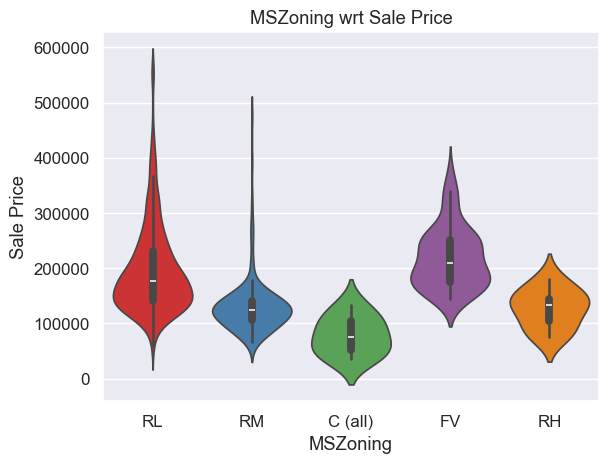

In [37]:
labels = train_df["MSZoning"].unique()
sizes = train_df["MSZoning"].value_counts().values
explode = [0.1, 0, 0, 0, 0]
percent = (sizes/sizes.sum())*100
labels = ['{0} - {1:1.1f} %'.format(i,j) for i,j in zip(labels, percent)]

patches, texts = plt.pie(sizes, explode=explode,
                         shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")
plt.title("Zoning Classification")
plt.show()


# Use keyword arguments (x, y, and data) for the violin plot
sns.violinplot(x="MSZoning", y="SalePrice", data=train_df, palette='Set1')
plt.title("MSZoning wrt Sale Price")
plt.xlabel("MSZoning")
plt.ylabel("Sale Price")

##### 1st Floor in square feet

Text(0.5, 0, '1st Floor in square feet')

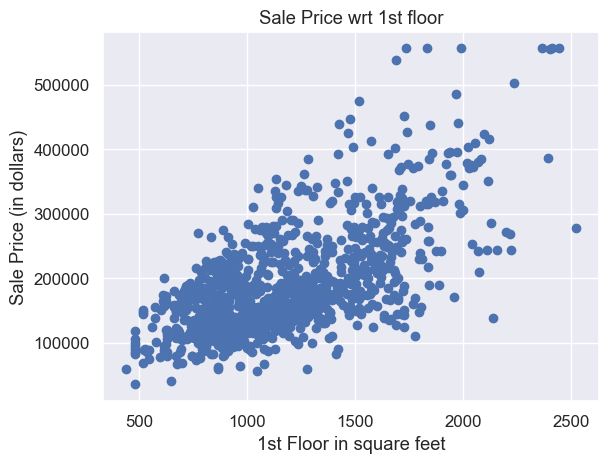

In [38]:
plt.scatter(train_df["1stFlrSF"],train_df.SalePrice)
plt.title("Sale Price wrt 1st floor")
plt.ylabel('Sale Price (in dollars)')
plt.xlabel("1st Floor in square feet")

##### Ground Living Area w.r.t. SalePrice

Text(0.5, 0, 'Ground living area')

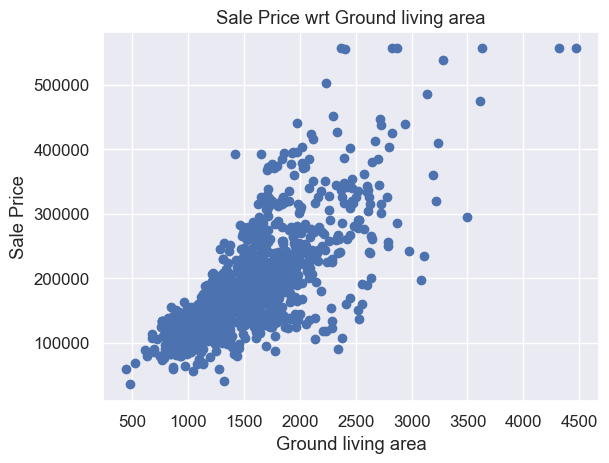

In [39]:
plt.scatter(train_df.GrLivArea,train_df.SalePrice)
plt.title("Sale Price wrt Ground living area")
plt.ylabel('Sale Price')
plt.xlabel("Ground living area")

##### SalePrice per square foot

Text(0.5, 0, 'Price per square feet')

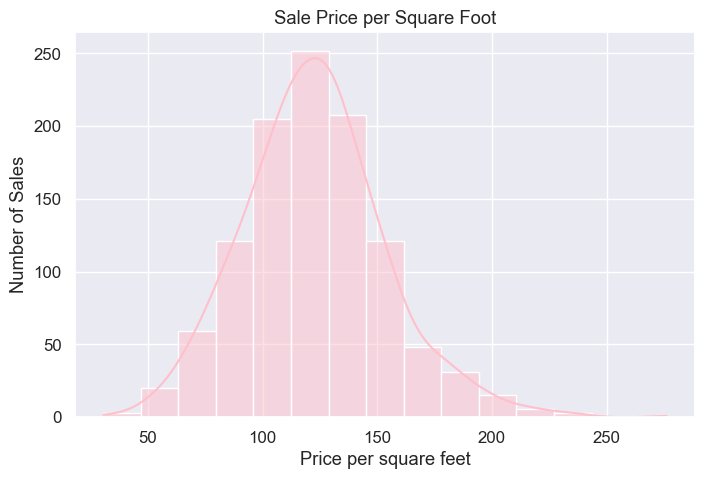

In [40]:
train_df['SalePriceSF'] = train_df['SalePrice']/train_df['GrLivArea']
plt.figure(figsize=(8, 5))
sns.histplot(x=train_df['SalePriceSF'], bins=15, color="pink", kde=True)
plt.title("Sale Price per Square Foot")
plt.ylabel('Number of Sales')
plt.xlabel('Price per square feet')

##### Garage Area

Text(0.5, 0, 'Garage Area in sq foot')

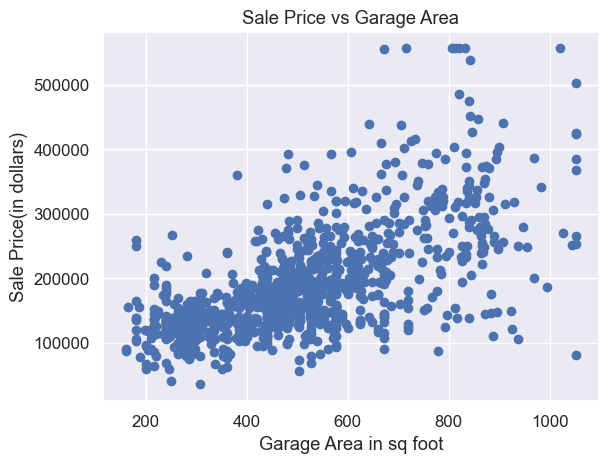

In [41]:
plt.scatter(train_df["GarageArea"],train_df.SalePrice)
plt.title("Sale Price vs Garage Area")
plt.ylabel('Sale Price(in dollars)')
plt.xlabel("Garage Area in sq foot")

In [42]:
# Average Sale Price per square feet
print("$", train_df.SalePriceSF.mean())

$ 122.71700374405344


##### Building, remodelling years and age of house

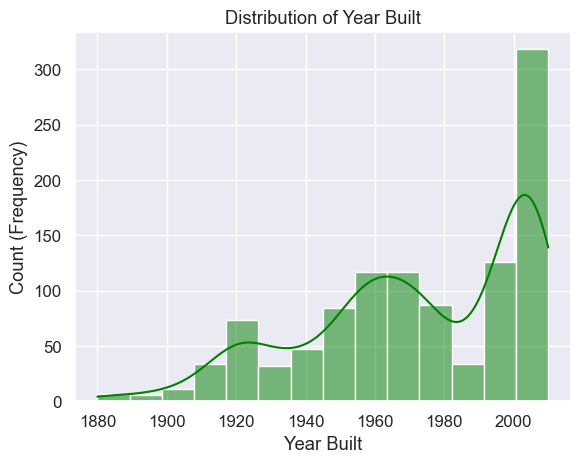

In [43]:
# Replace sns.distplot(..., kde=False) with sns.histplot(...)
sns.histplot(x=train_df["YearBuilt"], color='green', kde=True)

plt.title("Distribution of Year Built")
plt.xlabel("Year Built")
plt.ylabel("Count (Frequency)")
plt.show()

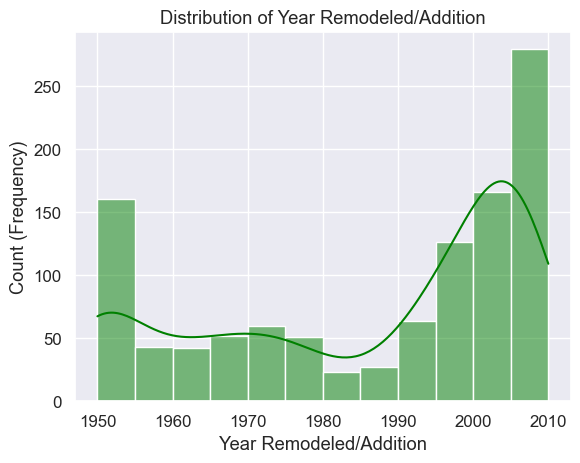

In [44]:
# Replace sns.distplot(..., kde=False) with sns.histplot(...)
# Note: We can remove 'kde=False' as histplot's default is False
sns.histplot(x=train_df["YearRemodAdd"].astype(int), color='green', kde=True)

plt.title("Distribution of Year Remodeled/Addition")
plt.xlabel("Year Remodeled/Addition")
plt.ylabel("Count (Frequency)")
plt.show()

Text(0.5, 0, 'Construction Age of house')

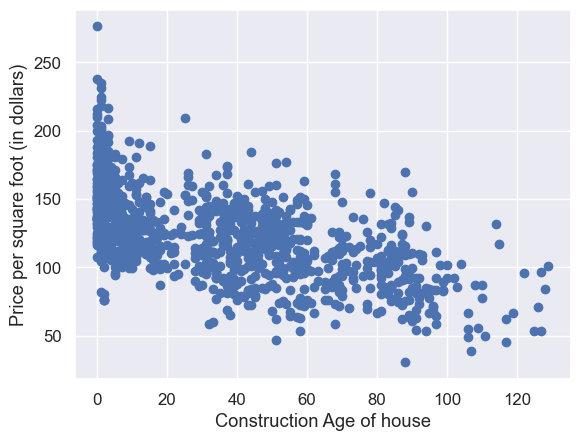

In [45]:
train_df['ConstructionAge'] = train_df['YrSold'] - train_df['YearBuilt']
plt.scatter(train_df['ConstructionAge'], train_df['SalePriceSF'])
plt.ylabel('Price per square foot (in dollars)')
plt.xlabel("Construction Age of house")

###### Price of house goes down with its age.

##### Heating and AC arrangements

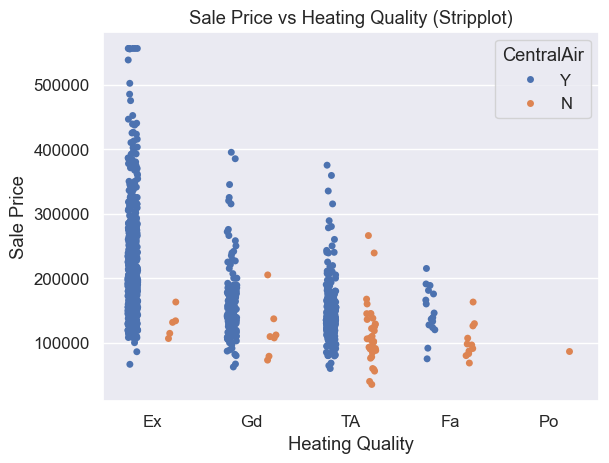

In [46]:
sns.stripplot(x="HeatingQC", y="SalePrice", data=train_df, hue='CentralAir', jitter=True, dodge=True)

plt.title("Sale Price vs Heating Quality (Stripplot)")
plt.xlabel("Heating Quality")
plt.ylabel("Sale Price")
plt.show()

##### Bathrooms in house

Text(0.5, 1.0, 'Sale Price vs Full Bathrooms')

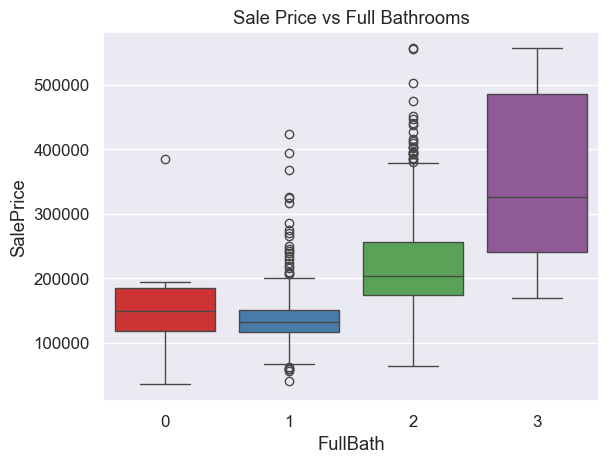

In [47]:
sns.boxplot(x="FullBath", y="SalePrice", data=train_df, palette='Set1')
plt.title("Sale Price vs Full Bathrooms")

Text(0.5, 1.0, 'Sale Price vs Half Bathrooms')

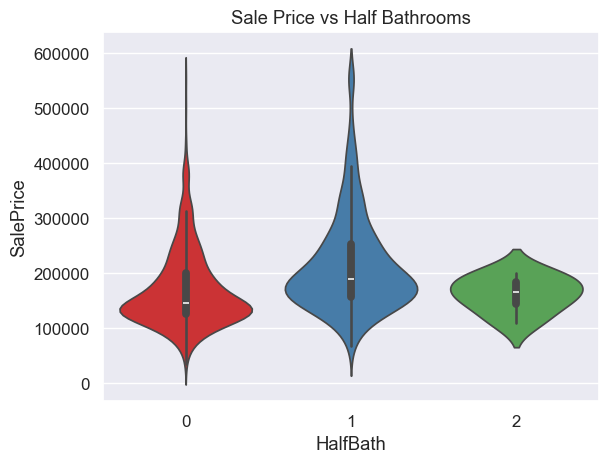

In [48]:
sns.violinplot(x="HalfBath", y="SalePrice", data=train_df, palette='Set1')
plt.title("Sale Price vs Half Bathrooms")

##### Total rooms above grade

Text(0.5, 1.0, 'Sale Price vs Number of rooms')

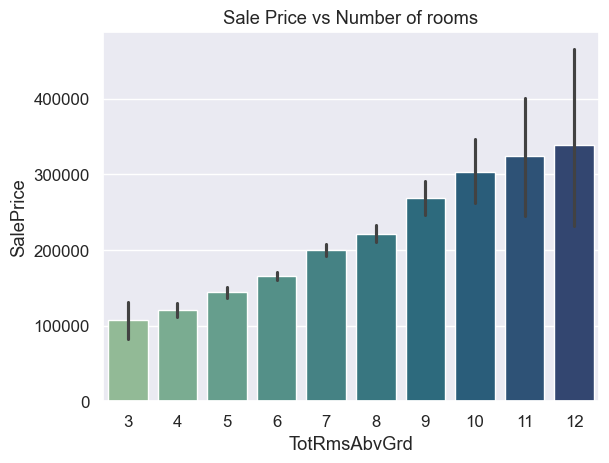

In [49]:
sns.barplot(x="TotRmsAbvGrd", y="SalePrice", data=train_df, palette="crest")
plt.title("Sale Price vs Number of rooms")

##### Kitchen Quality

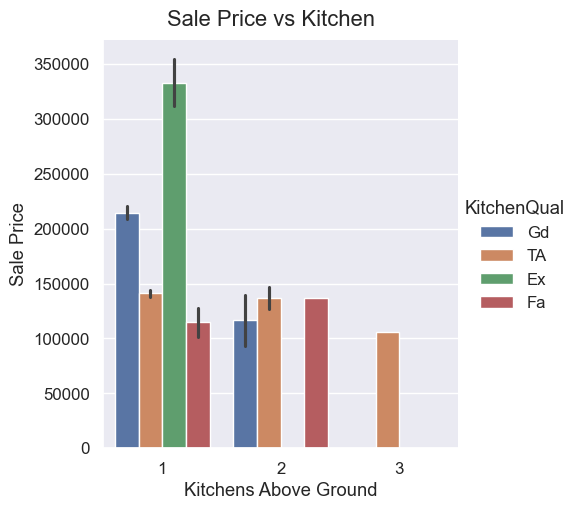

In [50]:
# Replace sns.factorplot with sns.catplot
g = sns.catplot(x="KitchenAbvGr", y="SalePrice", data=train_df, hue="KitchenQual", kind='bar')

# Use the FacetGrid object (g) to set figure properties
g.fig.suptitle("Sale Price vs Kitchen", y=1.02)
g.set_axis_labels("Kitchens Above Ground", "Sale Price")

plt.show()

##### Neighbourhood

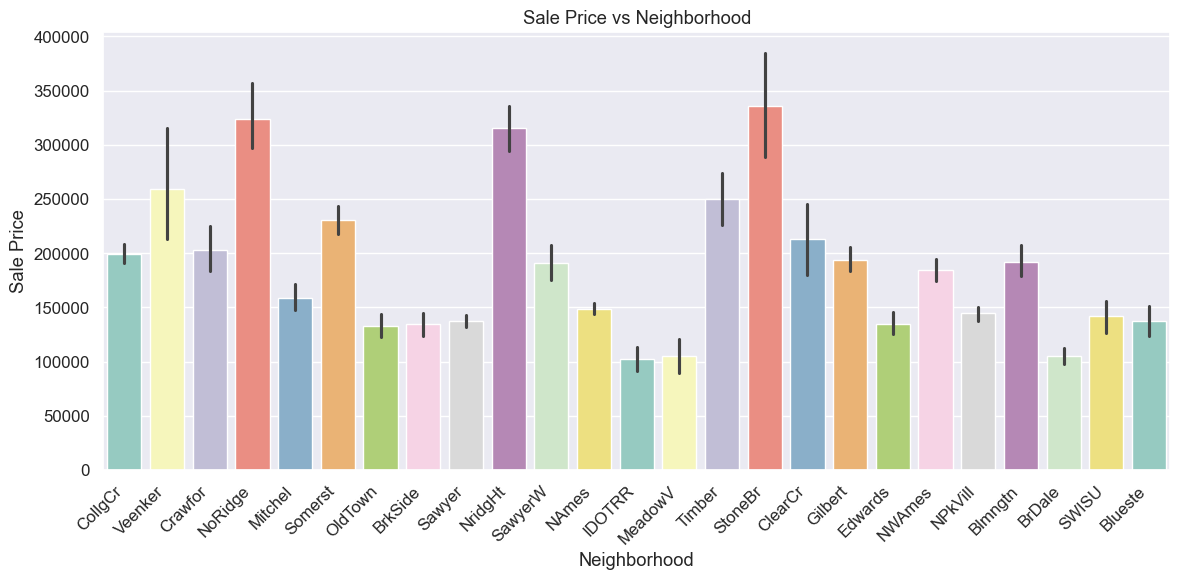

In [51]:
# Set figure size before the plot
plt.figure(figsize=(12, 6))

# Correct: Use keyword arguments x, y, and data
sns.barplot(x="Neighborhood", y="SalePrice", data=train_df, palette='Set3')

# Apply title and formatting
plt.title("Sale Price vs Neighborhood")
plt.xlabel("Neighborhood")
plt.ylabel("Sale Price")
plt.xticks(rotation=45, ha='right') # Rotate and align X-ticks
plt.tight_layout() 

plt.show()

##### Overall Quality

Text(0.5, 0, 'Sale Price')

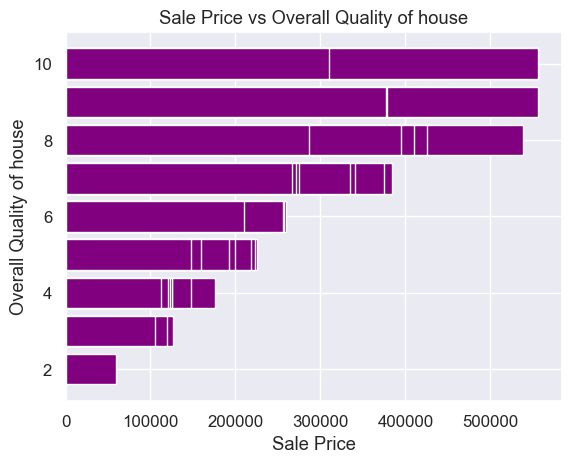

In [52]:
plt.barh(train_df["OverallQual"], width=train_df["SalePrice"], color="purple")
plt.title("Sale Price vs Overall Quality of house")
plt.ylabel("Overall Quality of house")
plt.xlabel("Sale Price")

##### 2nd Floor with SalePrice

Text(0, 0.5, 'Sale Price')

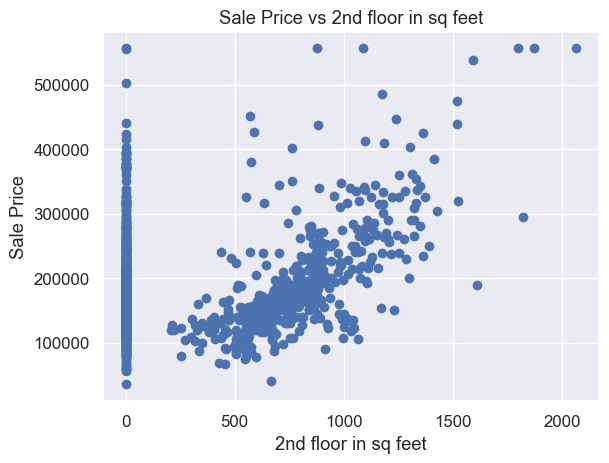

In [53]:
plt.scatter(train_df["2ndFlrSF"],train_df["SalePrice"])
plt.title("Sale Price vs 2nd floor in sq feet");
plt.xlabel("2nd floor in sq feet")
plt.ylabel("Sale Price")

##### Street

Text(0.5, 1.0, 'Sale Price vs Streets')

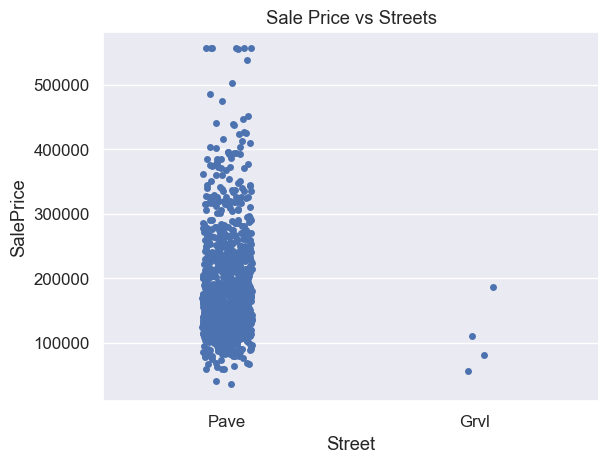

In [54]:
# Most streets are paved lets visualize it
sns.stripplot(x=train_df["Street"], y=train_df["SalePrice"], jitter=True)
plt.title("Sale Price vs Streets")

### Target Variable


 mu = 186547.20 and sigma = 80460.29



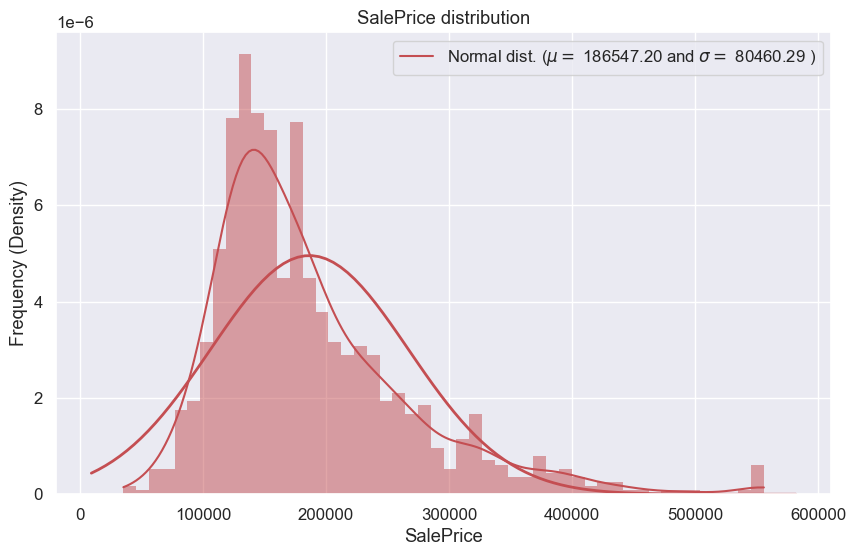

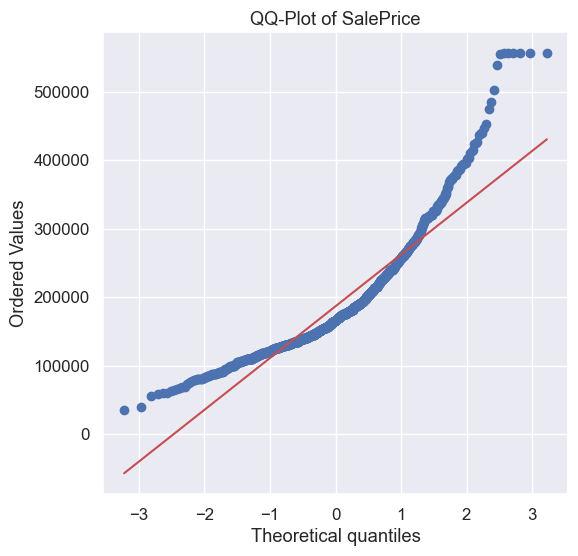

In [55]:
# 1. Fit a normal distribution to the data
(mu, sigma) = norm.fit(train_df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# 2. Plot the distribution using sns.histplot(recommended replacement for distplot)
plt.figure(figsize=(10, 6))

# Use histplot to show the histogram and kde (density)
sns.histplot(train_df['SalePrice'], kde=True, bins=50, color='r', stat="density", linewidth=0)

# Optional: Manually plot the fitted normal distribution line
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency (Density)')
plt.title('SalePrice distribution')
plt.show()

# 3. Get the QQ-plot
fig = plt.figure(figsize=(6, 6))
res = stats.probplot(train_df['SalePrice'], plot=plt)

# Use train_df
plt.title('QQ-Plot of SalePrice')
plt.show()

###### The target variable is right skewed. As linear models require normally distributed data , we need to transform this variable and make it more normally distributed.

##### Log-transformation of the Target variable


 mu = 12.06 and sigma = 0.39



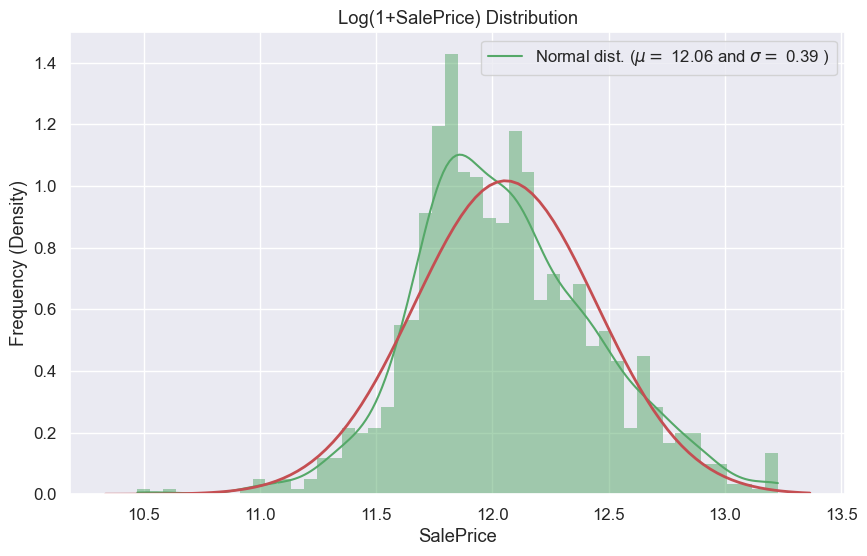

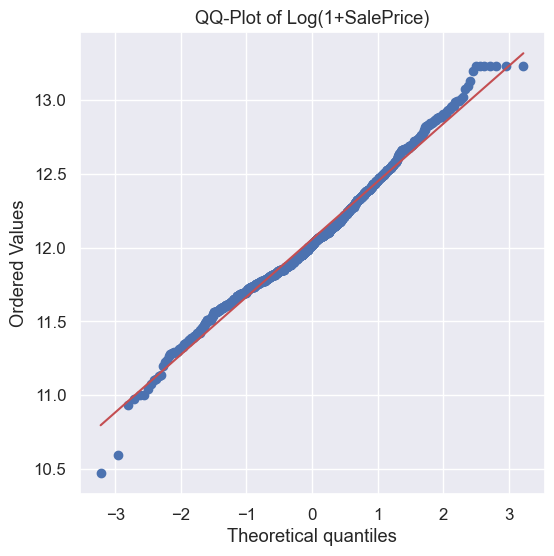

In [56]:
# Apply the log(1+x) transformation
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Create the plot
plt.figure(figsize=(10, 6))

# FIX: Use sns.histplot (recommended replacement) with stat="density" and manually plot the fitted line
sns.histplot(train_df['SalePrice'], kde=True, bins=50, color='g', stat="density", linewidth=0)

# Manually plot the fitted normal distribution line
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2)

# Add plot details
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency (Density)')
plt.title('Log(1+SalePrice) Distribution')
plt.show()

# Get the QQ-plot
fig = plt.figure(figsize=(6, 6))
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.title('QQ-Plot of Log(1+SalePrice)')
plt.show()

###### The skew seems now corrected and the data appears more normally distributed.

##### Scatter plots between 'SalePrice' and correlated variables

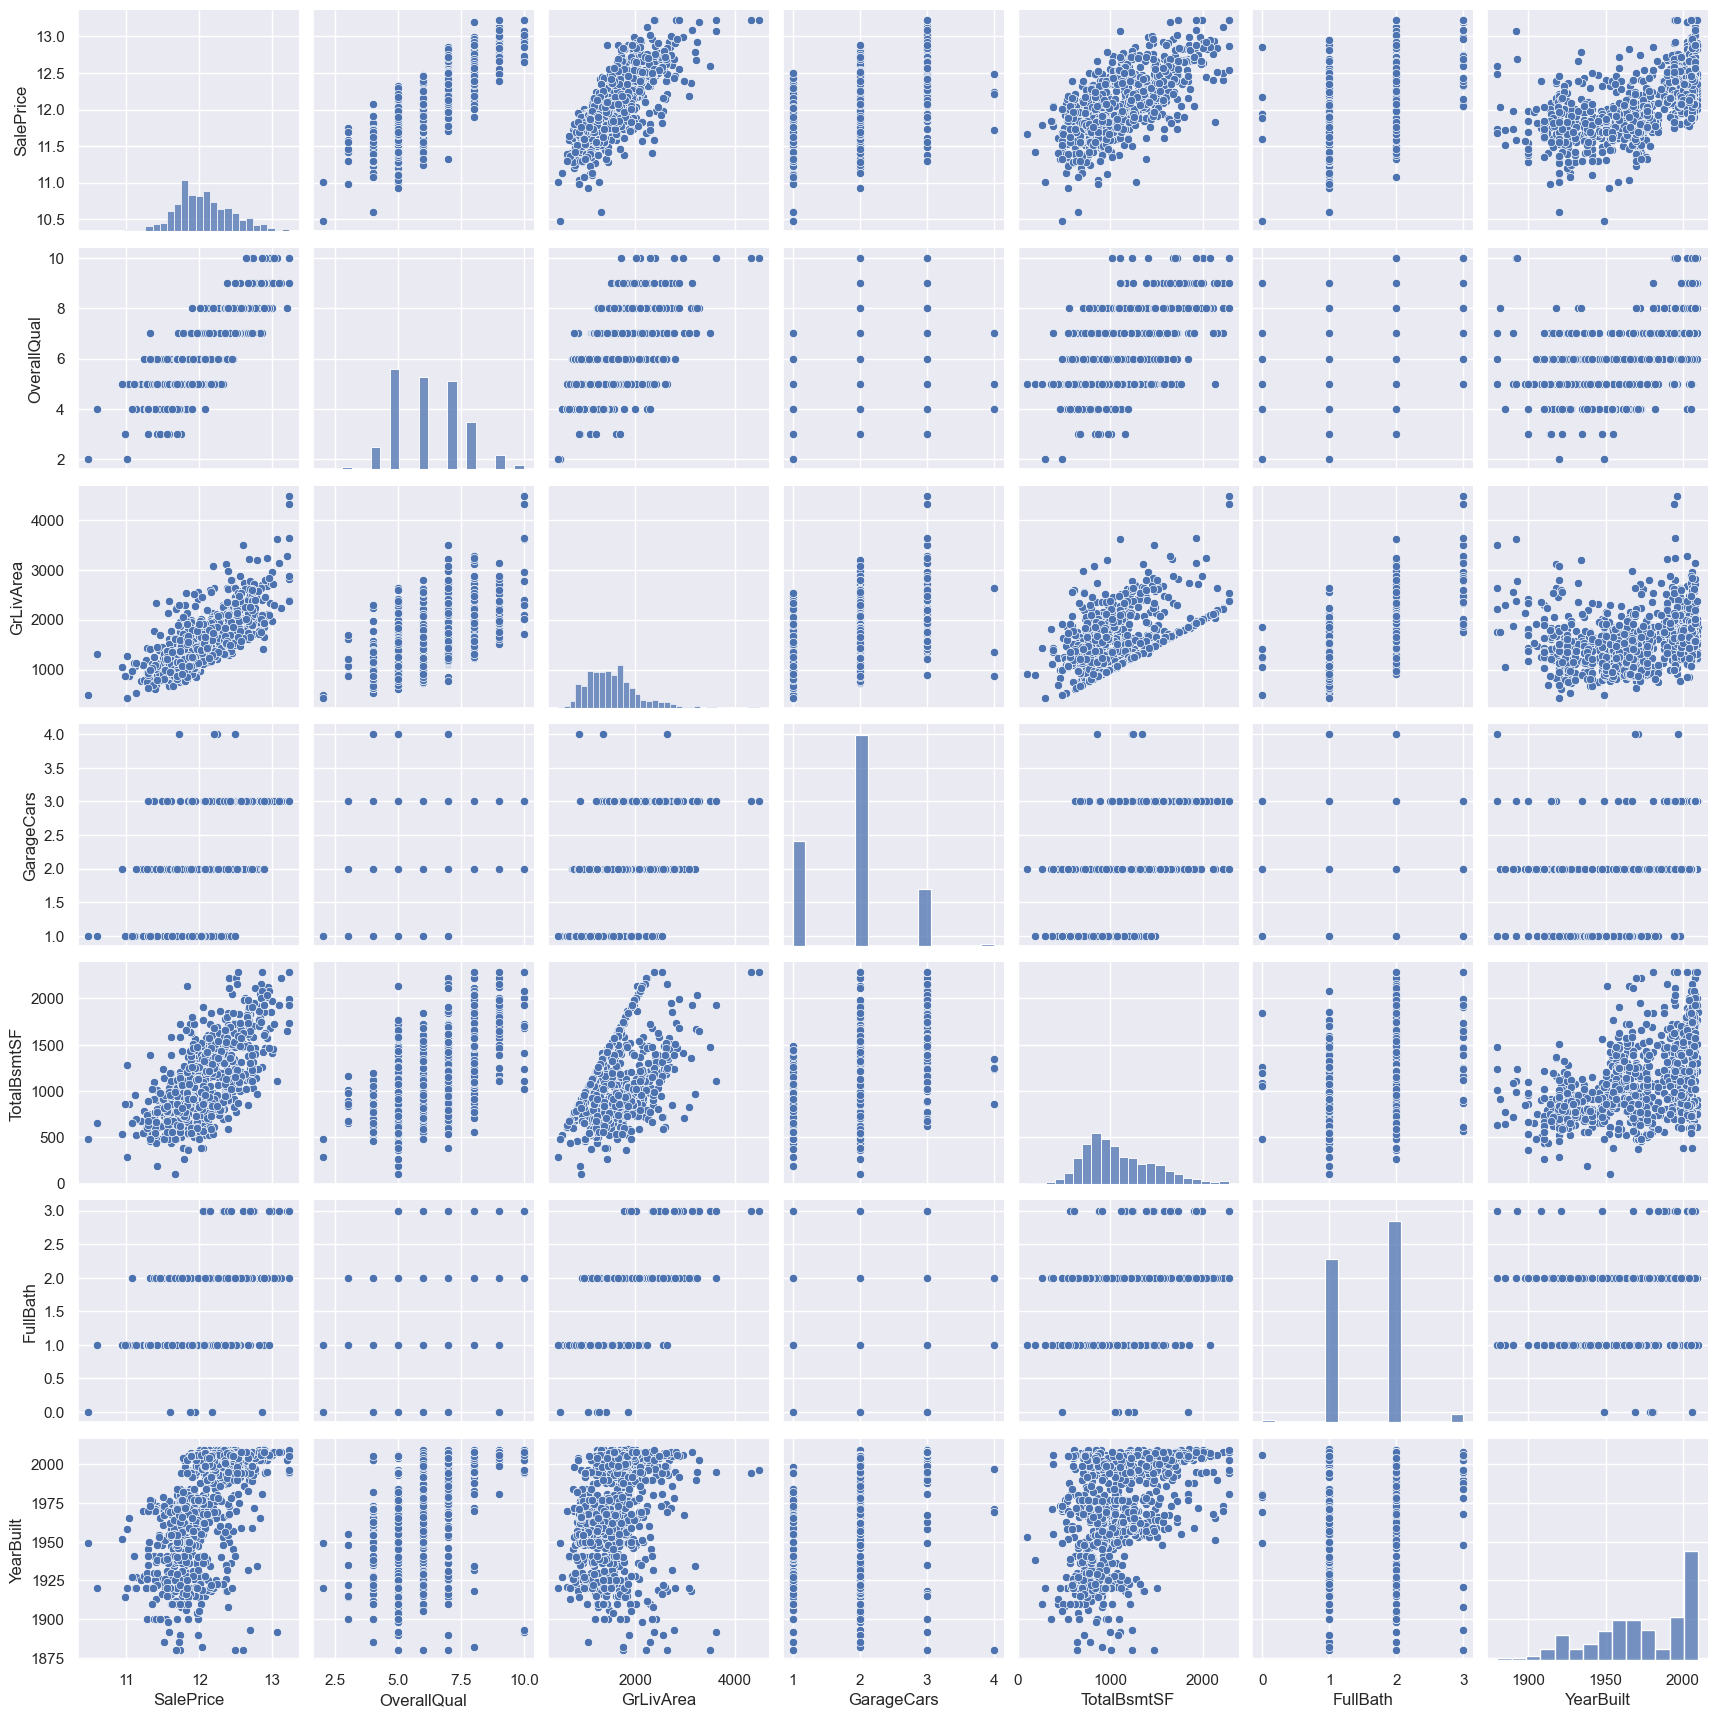

In [57]:
# Scatter plot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train_df[cols], size = 2.5)
plt.show()

###### One of the figures we may find interesting is the one between 'TotalBsmtSF' and 'GrLiveArea'. In this figure we can see the dots drawing a linear line, which almost acts like a border. It totally makes sense that the majority of the dots stay below that line. Basement areas can be equal to the above ground living area, but it is not expected a basement area bigger than the above ground living area.
###### The plot concerning 'SalePrice' and 'YearBuilt' can also make us think. In the bottom of the 'dots cloud', we see what almost appears to be a exponential function. We can also see this same tendency in the upper limit of the 'dots cloud'. Also, notice that prices are increasing faster now.
###### How 'SalePrice' complies with the statistical assumptions that enables us to apply multivariate techniques?
###### Normality - By normality we mean, the data should look like a normal distribution. This is important because several statistical tests rely on this (e.g. t-statistics). Beside that, if we solve normality, we avoid a lot of other problems (e.g. heteroscedacity).
###### Homoscedasticity - Homoscedasticity refers to the 'assumption that dependent variable(s) exhibit equal levels of variance across the range of predictor variable(s)' (Hair et al., 2013). Homoscedasticity is desirable because we want the error term to be the same across all values of the independent variables.
###### Linearity- The most common way to assess linearity is to examine scatter plots and search for linear patterns. If patterns are not linear, it would be worthwhile to explore data transformations.
###### Absence of correlated errors - When one error is correlated to another. For instance, if one positive error makes a negative error systematically, it means that there's a relationship between these variables. 

### Normality Check
##### Ground Living Area 

In [58]:
# Data transformation
train_df['GrLivArea'] = np.log(train_df['GrLivArea'])


 mu = 7.28 and sigma = 0.32



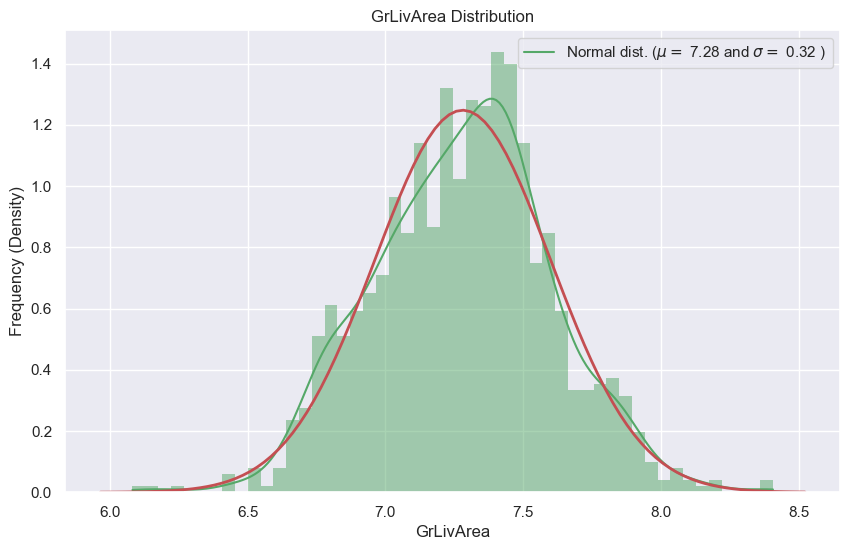

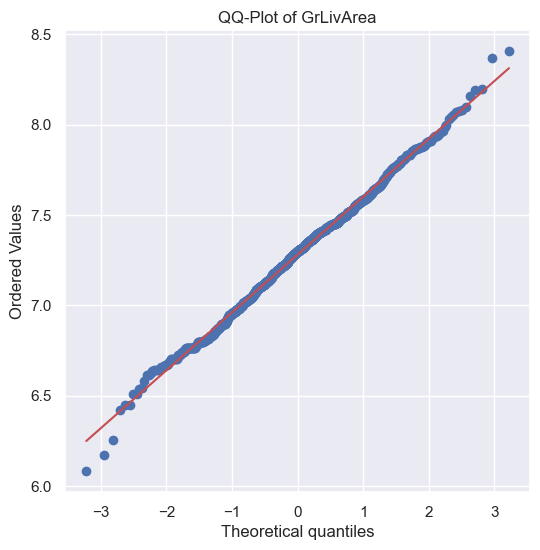

In [59]:
# 1. Fit a normal distribution to the data
(mu, sigma) = norm.fit(train_df['GrLivArea'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Create the plot
plt.figure(figsize=(10, 6))

# FIX 1: Use sns.histplot (recommended replacement) with stat="density"
sns.histplot(train_df['GrLivArea'], kde=True, bins=50, color='g', stat="density", linewidth=0)

# Manually plot the fitted normal distribution line
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2) 

# Add plot details
plt.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency (Density)')
plt.title('GrLivArea Distribution')
plt.show()

# 2. Plot QQ-plot (Normal Probability Plot)
fig = plt.figure(figsize=(6, 6))
res = stats.probplot(train_df['GrLivArea'], plot=plt)
plt.title('QQ-Plot of GrLivArea')
plt.show()

##### Basement Area


 mu = 1091.09 and sigma = 377.65



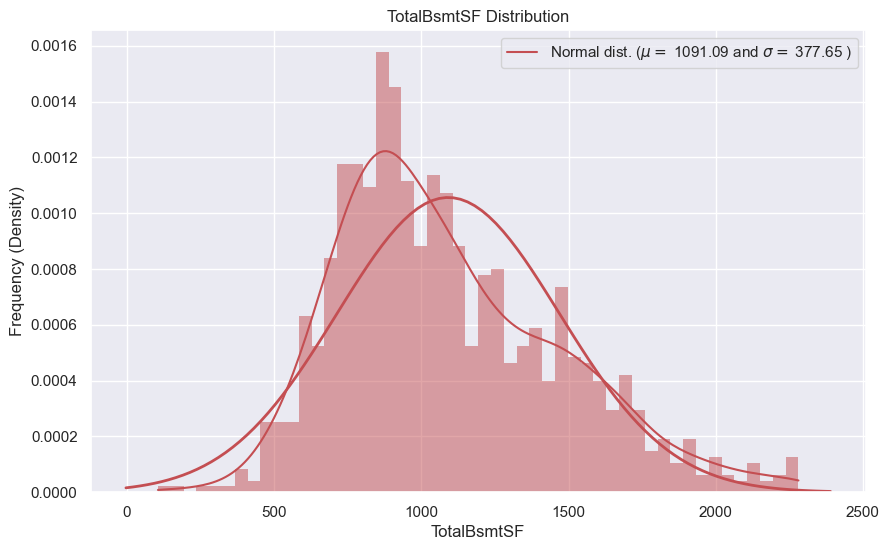

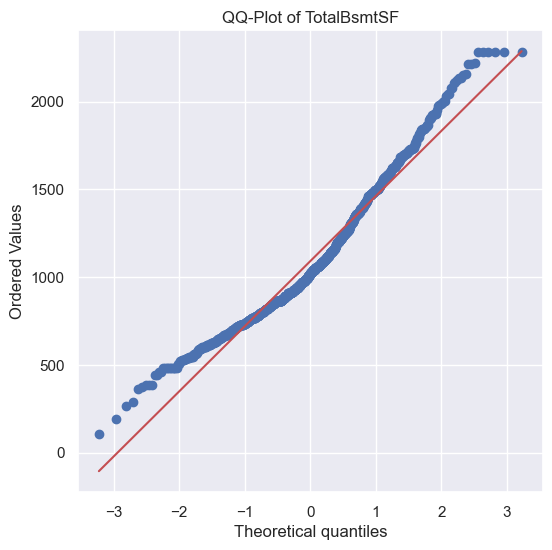

In [60]:
# 1. Fit a normal distribution to the data
(mu, sigma) = norm.fit(train_df['TotalBsmtSF'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Create the plot
plt.figure(figsize=(10, 6))

# FIX 1: Use sns.histplot (recommended replacement) with stat="density"
sns.histplot(train_df['TotalBsmtSF'], kde=True, bins=50, color='r', stat="density", linewidth=0)

# Manually plot the fitted normal distribution line
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2) 

# Add plot details
plt.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency (Density)')
plt.title('TotalBsmtSF Distribution')
plt.show()

# 2. Plot QQ-plot (Normal Probability Plot)
fig = plt.figure(figsize=(6, 6))
res = stats.probplot(train_df['TotalBsmtSF'], plot=plt)
plt.title('QQ-Plot of TotalBsmtSF')
plt.show()

###### Presence of skewness. A significant number of observations with value zero (houses without basement). The value zero doesn't allow us to do log transformations. To apply a log transformation here, we'll create a variable that can get the effect of having or not having basement (binary variable). Then, we'll do a log transformation to all the non-zero observations, ignoring those with value zero. This way we can transform data, without losing the effect of having or not basement.

In [61]:
# Create column for new variable (one is enough because it's a binary categorical feature)
# If area>0 it gets 1, for area==0 it gets 0
train_df['HasBsmt'] = pd.Series(len(train_df['TotalBsmtSF']), index=train_df.index)
train_df['HasBsmt'] = 0
train_df.loc[train_df['TotalBsmtSF'] > 0, 'HasBsmt'] = 1

In [62]:
# Transform data
train_df.loc[train_df['HasBsmt']==1, 'TotalBsmtSF'] = np.log(train_df['TotalBsmtSF'])


 mu = 6.93 and sigma = 0.35



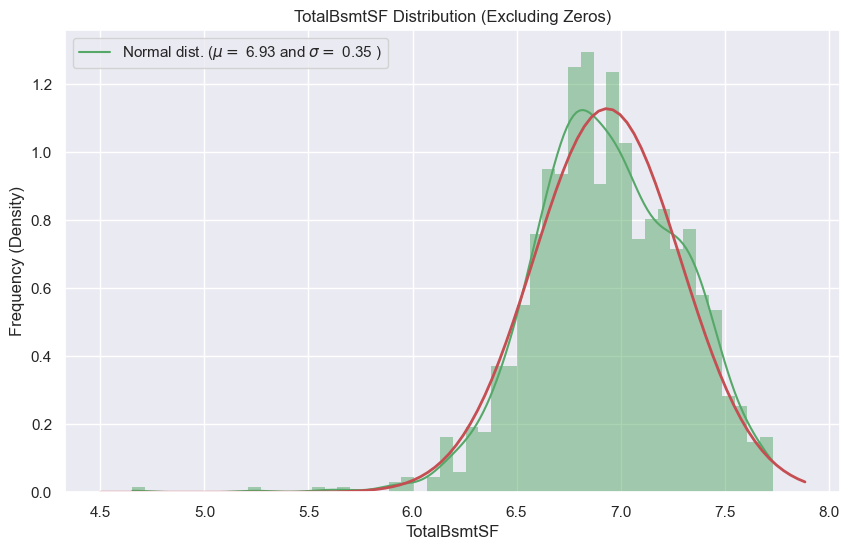

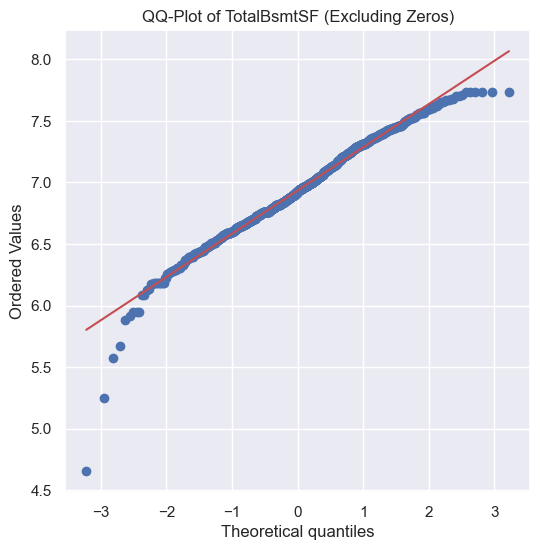

In [63]:
# Filter the data to include only houses with a basement
filtered_bsmt = train_df[train_df['TotalBsmtSF'] > 0]['TotalBsmtSF']

# 1. Fit a normal distribution to the filtered data
(mu, sigma) = norm.fit(filtered_bsmt)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Create the plot
plt.figure(figsize=(10, 6))

# FIX 1: Use sns.histplot (recommended replacement) with stat="density"
sns.histplot(filtered_bsmt, kde=True, bins=50, color='g', stat="density", linewidth=0)

# Manually plot the fitted normal distribution line
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2) 

# Add plot details
plt.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency (Density)')
plt.title('TotalBsmtSF Distribution (Excluding Zeros)')
plt.show()

# 2. Plot QQ-plot (Normal Probability Plot)
fig = plt.figure(figsize=(6, 6))
res = stats.probplot(filtered_bsmt, plot=plt)
plt.title('QQ-Plot of TotalBsmtSF (Excluding Zeros)')
plt.show()

### Heteroscedasticity Check

###### One of the popular approaches to test homoscedasticity for two metric variables is graphical. Departures from an equal dispersion are shown by such shapes as cones (small dispersion at one side of the graph, large dispersion at the opposite side) or diamonds (a large number of points at the center of the distribution).

##### 'SalePrice' and 'GrLivArea'

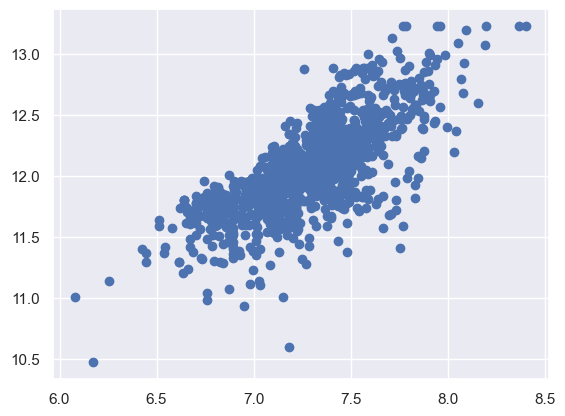

In [64]:
# Scatter plot
plt.scatter(train_df['GrLivArea'], train_df['SalePrice'])

###### Older versions of this scatter plot (previous to log transformations), had a conic shape. The current scatter plot doesn't have a conic shape anymore. By ensuring normality in some variables, we can solve the heteroscedasticity problem.

##### 'SalePrice' with 'TotalBsmtSF'

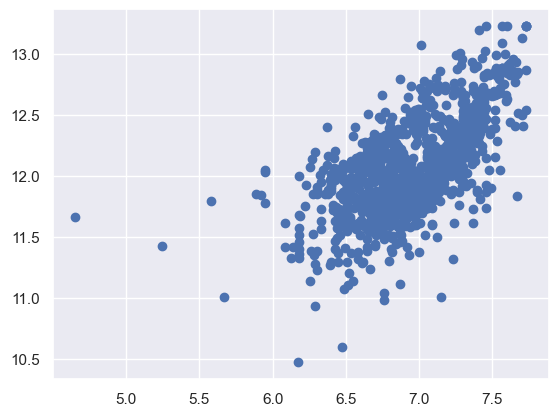

In [65]:
# Scatter plot
plt.scatter(train_df[train_df['TotalBsmtSF']>0]['TotalBsmtSF'], train_df[train_df['TotalBsmtSF']>0]['SalePrice'])

###### We can say that, in general, 'SalePrice' exhibits equal levels of variance across the range of 'TotalBsmtSF'.

### Pre-processing and Feature Engineering

In [ ]:
def addFeatures(df):

    df['YrBltAndRemod'] = df['YearBuilt'] + df['YearRemodAdd']
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['Total_sqr_feet'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['Total_Bathrooms'] = df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath'])
    df['Total_porch_sf'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF']

    return df

def encoding(df):

    ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
    categorical_cols = list(df.select_dtypes(include='object').columns)
    numerical_cols = list(df.select_dtypes(include='number').columns)

    encoded_values = ohe.fit_transform(df[categorical_cols])
    encoded_cols = list(ohe.get_feature_names_out())
    df_encoded = pd.DataFrame(encoded_values, columns=encoded_cols, index=df.index)
    df_numerical = df[numerical_cols]
    df_new = pd.concat([df_numerical, df_encoded], axis=1)

    return df_new

###### There are some outliers in the training dataset.

###### Here, I'm concatenating the training and test datasets to preprocess them.

In [67]:
all_df = pd.concat([train_df, test_df])

index = train_df.shape[0]
target = all_df.iloc[:index]['SalePrice']

all_df = addFeatures(all_df)
all_df = encoding(all_df)
id = all_df['Id']
all_df.drop(columns=['Id', 'SalePrice'], inplace=True)

### Training

###### I'm using XGBoost and Ridge Regressor, then Linear Regression to stack them. I've used Optuna to tune the XGBoost regressor.

In [68]:
xgb_params = {'max_depth': 4, 'learning_rate': 8.75e-3, 'n_estimators': 3515, 'min_child_weight': 2, 'colsample_bytree': 0.2050378195385253, 'subsample': 0.40369887914955715, 'reg_alpha': 0.3301567121037565, 'reg_lambda': 0.046181862052743}
xgbr = xgb.XGBRegressor(**xgb_params, random_state=42)
model = [
    ('ridge', Ridge(alpha=15)),
    ('XGB', xgbr),
]
stack = StackingRegressor(estimators=model, final_estimator=LinearRegression())

stack.fit(all_df.iloc[:index], np.log1p(target.values))

,estimators,"[('ridge', ...), ('XGB', ...)]"
,final_estimator,LinearRegression()
,cv,None
,n_jobs,None
,passthrough,False
,verbose,0
,alpha,15
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001


In [69]:
imputer = SimpleImputer(strategy='mean')
all_df_imputed = imputer.fit_transform(all_df)
all_df_clean = pd.DataFrame(all_df_imputed, columns=all_df.columns, index=all_df.index)

### Output

In [70]:
predict = stack.predict(all_df_clean)

output = pd.DataFrame({
    'Id' : id[index:],
    'SalePrice' : np.exp(predict[index:])
})

output.to_csv('sample_submission.csv', index=False)